In [ ]:
#!pip install sklearn

In [45]:
import warnings
warnings.filterwarnings("ignore")
from keras.layers import Input, Dense,Conv1D, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dropout, Reshape, Embedding, LSTM, GlobalMaxPooling1D
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation
from keras.models import Model
from keras.models import Sequential
from keras import backend as K
from keras import utils, optimizers
from keras.utils.np_utils import to_categorical
from keras.datasets import cifar10
import numpy as np
from keras.callbacks import TensorBoard
import matplotlib.pyplot as plt
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.optimizers import SGD, RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
#import cv2
import pandas as pd
import requests
import sys
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

<b> 1. AUTOENCODER <b>

In [2]:
(trainX, trainY), (testX, testY) = cifar10.load_data()

In [3]:
testX.shape
testY.shape
print(trainX.shape)
print(testX.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [7]:
trainX.shape
trainY.shape
print(trainY.shape)
print(testY.shape)

(50000, 1)
(10000, 1)


In [8]:
# one hot encode target values
trainY = to_categorical(trainY)
testY = to_categorical(testY)
#trainX, trainY, testX, testY

In [9]:
# Reshaping the data 32X32 (mentioned on the website)
trainX = np.reshape(trainX, (len(trainX), 32, 32, 3))
testX = np.reshape(testX, (len(testX), 32, 32, 3))

# We should normalize the following:
trainX = trainX.astype('float32') / 255
testX = testX.astype('float32') / 255

In [10]:
#Encoding Y
from keras.utils import np_utils
trainY = np_utils.to_categorical(trainY, 10)
testY = np_utils.to_categorical(testY, 10)

In [11]:
input_img = Input(shape=(32, 32, 3))
x = Conv2D(64, (3, 3), padding='same')(input_img)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(16, (3, 3), padding='same')(encoded)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(3, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
decoded = Activation('sigmoid')(x)

autoencoder= Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        18464     
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 32)        128 

In [12]:
auto_encoder_trained  = autoencoder.fit(trainX, trainX,
                    batch_size=512,
                    epochs=5,
                    verbose=1,
                    validation_data=(testX, testX),
                    shuffle=True)


Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 327s 7ms/step - loss: 0.6124 - val_loss: 0.6750
Epoch 2/5
50000/50000 [==============================] - 324s 6ms/step - loss: 0.5927 - val_loss: 0.6506
Epoch 3/5
50000/50000 [==============================] - 519s 10ms/step - loss: 0.5887 - val_loss: 0.6236
Epoch 4/5
50000/50000 [==============================] - 628s 13ms/step - loss: 0.5865 - val_loss: 0.5997
Epoch 5/5
50000/50000 [==============================] - 638s 13ms/step - loss: 0.5850 - val_loss: 0.5890


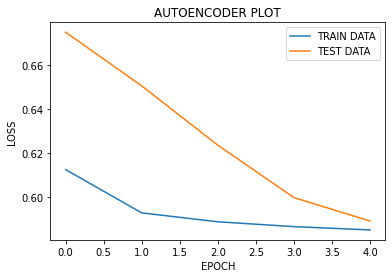

In [16]:
plt.plot(auto_encoder_trained.history['loss'])
plt.plot(auto_encoder_trained.history['val_loss'])
plt.title('AUTOENCODER PLOT')
plt.ylabel('LOSS')
plt.xlabel('EPOCH')
plt.legend(['TRAIN DATA', 'TEST DATA'], loc='upper right')
plt.show()

In [17]:
# Plotting the follwowing
def cifar10image(orig, dec, num=10):
    import matplotlib.pyplot as plt
    n = num
    plt.figure(figsize=(20, 4))

    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i+1)
        plt.imshow(orig[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i +1 + n)
        plt.imshow(dec[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

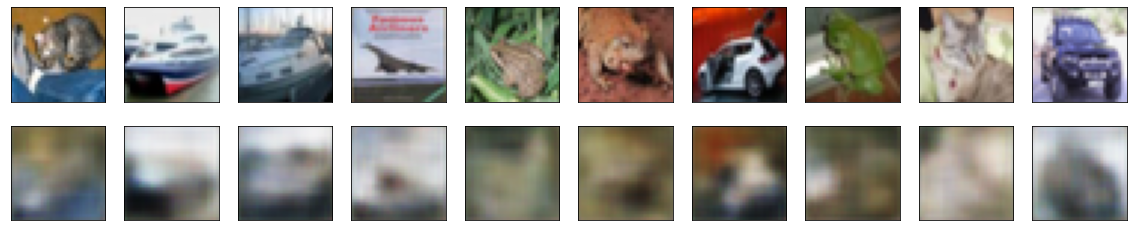

In [34]:
test10 = autoencoder.predict(testX)
cifar10image(testX,test10)

<B> 2. IMAGE CLASSIFICATION <b>

<b> 2.1 DEEP CNN <b> 
    
<i> Build a deep CNN to classify the images. Provide a brief description of the
architectural choices you’ve made: kernel sizes, strides, padding, network
depth.Train your network end-to-end. Report on your model’s performance
on the training set and test set. <i>

In [48]:
import numpy as np
import keras
from keras import layers
from keras import models
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score

In [18]:
(trainimage, trainlabel), (testimage, testlabel) = cifar10.load_data()
# Reshaping the data 32X32 (mentioned on the website)
trainimage = np.reshape(trainimage, (len(trainimage), 32, 32, 3))
testimage = np.reshape(testimage, (len(testimage), 32, 32, 3))

trainimage = trainimage.reshape((50000,32,32,3))
trainimage = trainimage.astype('float32') / 255
testimage = testimage.reshape((10000, 32,32,3))
testimage = testimage.astype('float32') / 255
trainlabel= to_categorical(trainlabel)
testlabel = to_categorical(testlabel)

In [19]:
#Building the CCNN Model using similar information from the top.
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=3, strides=(1, 1), padding='same', activation='relu', input_shape=(32,32,3))) 
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))

model.add(Conv2D(filters=32, kernel_size=3, strides=(1, 1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
model.summary()

# Lets try the adam optimizer this time.
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 8, 8, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)             

In [29]:
from keras.callbacks import EarlyStopping 
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping
import keras
from keras import layers
from keras import models
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score

In [53]:
DeepCNN = model.fit(trainimage, trainlabel,
          epochs=5,
          batch_size=128,
          validation_split = 0.3)

Train on 35000 samples, validate on 15000 samples
Epoch 1/5
35000/35000 [==============================] - 50s 1ms/step - loss: 1.1195 - accuracy: 0.6097 - val_loss: 0.9365 - val_accuracy: 0.6828
Epoch 2/5
35000/35000 [==============================] - 51s 1ms/step - loss: 1.1092 - accuracy: 0.6067 - val_loss: 0.9620 - val_accuracy: 0.6702
Epoch 3/5
35000/35000 [==============================] - 51s 1ms/step - loss: 1.0839 - accuracy: 0.6178 - val_loss: 0.9136 - val_accuracy: 0.6965
Epoch 4/5
35000/35000 [==============================] - 45s 1ms/step - loss: 1.0753 - accuracy: 0.6251 - val_loss: 0.9471 - val_accuracy: 0.6823
Epoch 5/5
35000/35000 [==============================] - 51s 1ms/step - loss: 1.0661 - accuracy: 0.6271 - val_loss: 0.9007 - val_accuracy: 0.6883


In [54]:
accuracyscore = model.evaluate(testimage, testlabel, verbose=1)
print("The Final Test Score is: {acc}".format(acc = accuracyscore))

10000/10000 [==============================] - 4s 388us/step
The Final Test Score is: [0.9415119913101196, 0.6728000044822693]


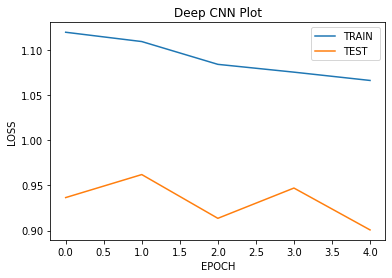

In [55]:
plt.plot(DeepCNN.history['loss'])
plt.plot(DeepCNN.history['val_loss'])
plt.title('Deep CNN Plot')
plt.ylabel('LOSS')
plt.xlabel('EPOCH')
plt.legend(['TRAIN ', 'TEST '], loc='upper right')
plt.show()

<b> 2.2 <b> 
Repeat the same task, but this time utilize a pre-trained network for the majority of your model. You should only train the final Dense layer, all other weights
should be fixed. You can use whichever pre-trained backbone you like (ResNet,
VGG, etc). Report on your model’s performance on the training set and test
set.

In [30]:
from keras.applications import VGG16
from keras.preprocessing.image import img_to_array, array_to_img

In [40]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
# Same steps as before
x_train = np.reshape(x_train, (len(x_train), 32, 32, 3))
x_test = np.reshape(x_test, (len(x_test), 32, 32, 3))
# We should normalize the following:
x_train = x_train.astype('float32') / 255
x_test= x_test.astype('float32') / 255

# Encode the y label
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)
x_train.shape
x_test.shape

(10000, 32, 32, 3)

In [41]:
VGGEX = VGG16(weights = 'imagenet', include_top = False, input_shape = (32,32,3))
VGGEX.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [42]:
model = models.Sequential()
model.add(VGGEX)
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))

# Freeze the convolutional base
print('This is the number of trainable weights before:', len(model.trainable_weights))
VGGEX.trainable = False
print('This is the number of trainable weights after:', len(model.trainable_weights))

This is the number of trainable weights before: 30
This is the number of trainable weights after: 4


In [44]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
VGGs = model.fit(x_train, y_train,
          epochs=5,
          batch_size=128,
          validation_split = 0.3)

Train on 35000 samples, validate on 15000 samples
Epoch 1/5
35000/35000 [==============================] - 997s 28ms/step - loss: 1.8390 - accuracy: 0.3499 - val_loss: 1.4661 - val_accuracy: 0.5027
Epoch 2/5
35000/35000 [==============================] - 1906s 54ms/step - loss: 1.5324 - accuracy: 0.4652 - val_loss: 1.3685 - val_accuracy: 0.5330
Epoch 3/5
35000/35000 [==============================] - 1265s 36ms/step - loss: 1.4405 - accuracy: 0.5007 - val_loss: 1.2944 - val_accuracy: 0.5523
Epoch 4/5
35000/35000 [==============================] - 986s 28ms/step - loss: 1.3942 - accuracy: 0.5141 - val_loss: 1.2789 - val_accuracy: 0.5607
Epoch 5/5
35000/35000 [==============================] - 506s 14ms/step - loss: 1.3653 - accuracy: 0.5244 - val_loss: 1.2392 - val_accuracy: 0.5686


In [46]:
accuracyscore2 = model.evaluate(x_test, y_test, verbose=1)
print("The Final Test Score is: {acc}".format(acc = accuracyscore2))

10000/10000 [==============================] - 84s 8ms/step
The Final Test Score is: [1.2596878799438476, 0.5590999722480774]


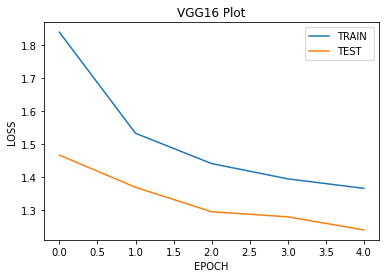

In [47]:
plt.plot(VGGs.history['loss'])
plt.plot(VGGs.history['val_loss'])
plt.title('VGG16 Plot')
plt.ylabel('LOSS')
plt.xlabel('EPOCH')
plt.legend(['TRAIN ', 'TEST '], loc='upper right')
plt.show()

<b> TEXT CLASSIFICATION <b>

<b> 3.1 <b>
Build and train a Recurrent Neural Network to solve this text classification
task. You can use any type of RNN you wish (SimpleRNN, GRU, LSTM).


In [43]:
#re-installing libraries. Just in case.
import os
import numpy as np
import pandas as pd
import nltk
from keras.models import Sequential
from keras.layers import Dense, Embedding, SimpleRNN, LSTM, GRU, Conv1D, MaxPooling1D, GlobalMaxPooling1D, MaxPool1D
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import TensorBoard, ModelCheckpoint
import matplotlib.pyplot as plt
from IPython.display import SVG, display
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from keras.layers import SimpleRNN, Embedding, Dense, LSTM
from keras.models import Sequential
import pandas as pd
import numpy as np
from keras.layers import SimpleRNN, Embedding, Dense, LSTM
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()

In [5]:
# Read data
data = pd.read_csv('SPAM_detection.csv', sep=',')

# Look at the data 
data.head(10)


,Message,category_val
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0
5,FreeMsg Hey there darling it's been 3 week's n...,1
6,Even my brother is not like to speak with me. ...,0
7,As per your request 'Melle Melle (Oru Minnamin...,0
8,WINNER!! As a valued network customer you have...,1
9,Had your mobile 11 months or more? U R entitle...,1


In [21]:
texts = []
labels = []
for i, label in enumerate(data['category_val']):
    texts.append(data['Message'][i])
    if label == 'ham':
        labels.append(0)
    else:
        labels.append(1)

texts = np.asarray(texts)
labels = np.asarray(labels)


print("Total for texts :" , len(texts))
print("Total for labels: ", len(labels))

Total for texts : 5572
Total for labels:  5572


In [22]:
data.describe()
duplicatedRow = data[data.duplicated()]
print(duplicatedRow[:5])

                                               Message  category_val
103  As per your request 'Melle Melle (Oru Minnamin...             0
154  As per your request 'Melle Melle (Oru Minnamin...             0
207  As I entered my cabin my PA said, '' Happy B'd...             0
223                             Sorry, I'll call later             0
326                   No calls..messages..missed calls             0


In [24]:
max_features = 10000
maxlen = 500


# to make it easier we will do a 80 20 split 
training_samples = int(5572 * .8)
validation_samples = int(5572 - training_samples)


In [27]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]


texts_train = data[:training_samples]
y_train = labels[:training_samples]
texts_test = data[training_samples:]
y_test = labels[training_samples:]

In [35]:
lstm_model = Sequential()
lstm_model.add(Embedding(max_features, 32))
lstm_model.add(LSTM(32))
lstm_model.add(Dense(1, activation ='sigmoid'))
lstm_model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics=['accuracy'])
lstm_trained = lstm_model.fit(texts_train, y_train,
                              epochs = 5, batch_size = 128,
                              validation_split =0.2)

C:\Users\Owner\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 3565 samples, validate on 892 samples
Epoch 1/5
3565/3565 [==============================] - 22s 6ms/step - loss: 0.1761 - accuracy: 0.9851 - val_loss: 0.0165 - val_accuracy: 1.0000
Epoch 2/5
3565/3565 [==============================] - 25s 7ms/step - loss: 0.0090 - accuracy: 1.0000 - val_loss: 0.0042 - val_accuracy: 1.0000
Epoch 3/5
3565/3565 [==============================] - 25s 7ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 4/5
3565/3565 [==============================] - 26s 7ms/step - loss: 9.4238e-04 - accuracy: 1.0000 - val_loss: 5.7030e-04 - val_accuracy: 1.0000
Epoch 5/5
3565/3565 [==============================] - 27s 8ms/step - loss: 3.8712e-04 - accuracy: 1.0000 - val_loss: 2.4187e-04 - val_accuracy: 1.0000


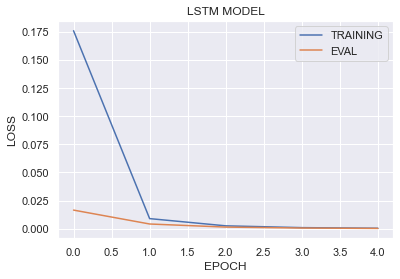

In [52]:
plt.plot(lstm_trained.history['loss'])
plt.plot(lstm_trained.history['val_loss'])
plt.title('LSTM MODEL')
plt.ylabel('LOSS')
plt.xlabel('EPOCH')
plt.legend(['TRAINING', 'EVAL'], loc='upper right')
plt.show()

In [37]:
pred = lstm_model.predict_classes(texts_test)
acc =lstm_model.evaluate(texts_test, y_test)
proba_rnn = lstm_model.predict_proba(texts_test)
from sklearn.metrics import confusion_matrix
print("Test loss is {0:.2f} accuracy is {1:.2f}  ".format(acc[0],acc[1]))
print(confusion_matrix(pred, y_test))

1115/1115 [==============================] - 2s 2ms/step
Test loss is 0.00 accuracy is 1.00  
[[1115]]


<b> 3.2 <b>
Build and train a 1D CNN for this text classification task. We recommend
you do a character-level convolution (with character embeddings). You might
gain some insight and inspiration from these text classification approaches:
1.http://www.aclweb.org/anthology/D14-1181
2.https://arxiv.org/abs/1702.08568
Tips: after splitting every character in each training sample, the maximum
length of training samples can be really big. If you choose to only do the
padding trick to all the samples, it might raise OOM issues. So instead of
padding only, you can also cut each sample at a certain point, which can make
training more efficient and feasible while using CNN.

In [46]:
modelCNN = Sequential()
modelCNN.add(Embedding(max_features, 128))
modelCNN.add(Conv1D(128, 3, activation='relu'))
modelCNN.add(MaxPool1D(3))
modelCNN.add(Dropout(0.2))
modelCNN.add(Conv1D(128, 3, activation='relu'))
modelCNN.add(GlobalMaxPooling1D())
modelCNN.add(Dropout(0.2))
modelCNN.add(Dense(64, activation='relu'))
modelCNN.add(Dropout(0.2))
modelCNN.add(Dense(32, activation='relu'))
modelCNN.add(Dropout(0.2))
modelCNN.summary()
modelCNN.add(Dense(1, activation='sigmoid'))

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 128)         1280000   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 128)         49280     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 128)         49280     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)              

In [47]:
modelCNN.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics=['accuracy'])
CNN_trained = modelCNN.fit(texts_train, y_train,
                              epochs = 5, batch_size = 128,
                              validation_split =0.2)

Train on 3565 samples, validate on 892 samples
Epoch 1/5
3565/3565 [==============================] - 13s 4ms/step - loss: 0.0698 - accuracy: 0.9846 - val_loss: 2.9796e-04 - val_accuracy: 1.0000
Epoch 2/5
3565/3565 [==============================] - 13s 4ms/step - loss: 1.5393e-04 - accuracy: 1.0000 - val_loss: 1.0037e-05 - val_accuracy: 1.0000
Epoch 3/5
3565/3565 [==============================] - 14s 4ms/step - loss: 1.4604e-05 - accuracy: 1.0000 - val_loss: 8.3233e-07 - val_accuracy: 1.0000
Epoch 4/5
3565/3565 [==============================] - 14s 4ms/step - loss: 2.1105e-06 - accuracy: 1.0000 - val_loss: 6.9124e-08 - val_accuracy: 1.0000
Epoch 5/5
3565/3565 [==============================] - 14s 4ms/step - loss: 5.3745e-07 - accuracy: 1.0000 - val_loss: 2.8927e-09 - val_accuracy: 1.0000


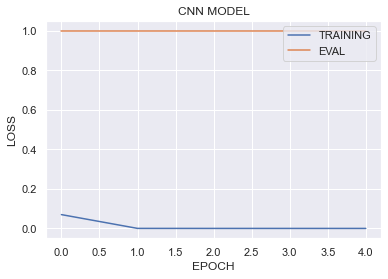

In [54]:
plt.plot(CNN_trained.history['loss'])
plt.plot(CNN_trained.history['val_accuracy'])
plt.title('CNN MODEL')
plt.ylabel('LOSS')
plt.xlabel('EPOCH')
plt.legend(['TRAINING', 'EVAL'], loc='upper right')
plt.show()

<b> 3.3 <b>
Be sure to directly compare your two methods with an ROC curve or similar
validation method. Don’t forget to create a train-test split.

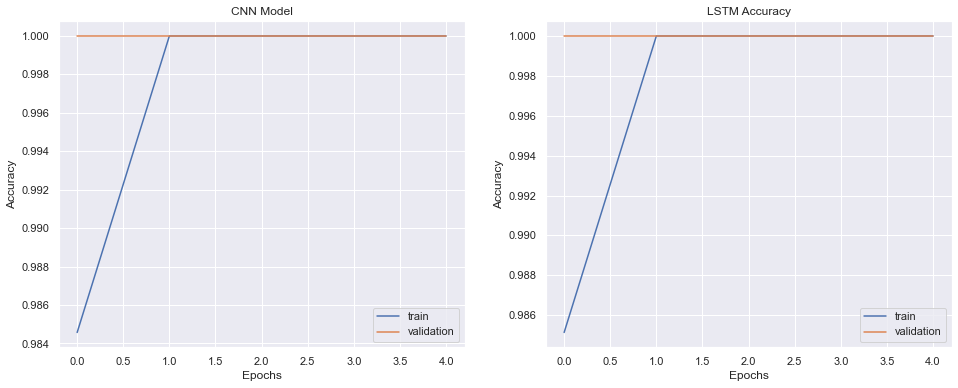

In [59]:
plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
plt.plot(CNN_trained.history['accuracy'])
plt.plot(CNN_trained.history['val_accuracy'])
plt.title('CNN Model')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])

plt.subplot(1, 2, 2)
plt.plot(lstm_trained.history['accuracy'])
plt.plot(lstm_trained.history['val_accuracy'])
plt.title('LSTM Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [63]:
# Calculate test loss and accuracy
lstm_loss, lstm_acc = lstm_model.evaluate(texts_test, y_test)
print('The loss for test LSTM:', lstm_loss)
print('The acc for test LSTM: %.2f%%' % (lstm_acc*100))

CNN_loss, CNN_acc = modelCNN.evaluate(texts_test, y_test)
print('The loss for test CNN:', CNN_loss)
print('The acc for test CNN: %.2f%%' % (CNN_acc*100))

1115/1115 [==============================] - 2s 2ms/step
The loss for test LSTM: 0.00024197821817548753
The acc for test LSTM: 100.00%
1115/1115 [==============================] - 1s 1ms/step
The loss for test CNN: 2.8939380583980995e-09
The acc for test CNN: 100.00%
